In [1]:
import os, sys, time, copy
import numpy as np
import matplotlib.pyplot as plt

import myokit
sys.path.append('../')
sys.path.append('../Protocols')
sys.path.append('../Models')
sys.path.append('../Lib')
import protocol_lib
import mod_trace

import simulator_myokit
import simulator_scipy

In [2]:
end_time = 1000
bcl = 1000
duration = 0.5
offset = 20

t_span = (0, end_time)
t_eval = np.linspace(0, t_span[1], 5000)  

In [3]:
start_time = time.time()

model_path = "../mmt-model-files/ord-2011.mmt" 
model, p, s = myokit.load(model_path)
protocol = myokit.pacing.blocktrain(bcl, duration, offset=offset) # period, duration, offset=0, level=1.0, limit=0  
sim = simulator_myokit.Simulator(model, protocol, max_step=1.0, abs_tol=1e-06, rel_tol=1e-6, vhold=0)  # 1e-12, 1e-14  # 1e-08, 1e-10
sim.name = "ORD2011"  
sim.simulation.set_constant('cell.mode', 1)    
y0 = sim.pre_simulate(bcl*100, sim_type=1)
d = sim.simulate(end_time, log_times=None, extra_log=['ina.INa', 'ikr.IKr', 'iks.IKs', 'ito.Ito', 'ical.ICaL', 'ik1.IK1', 'inal.INaL'])

sol1 = {}
times1 = d['engine.time']
sol1["Voltage"] = d['membrane.V']
sol1["I_Na"] = d['ina.INa']
sol1["I_Kr"] = d['ikr.IKr']
sol1["I_Ks"] = d['iks.IKs']
sol1["I_To"] = d['ito.Ito']
sol1["I_CaL"] = d['ical.ICaL']
sol1["I_K1"] = d['ik1.IK1']
sol1["I_NaL"] = d['inal.INaL']
I_total = np.zeros_like(times1)
for i, (name, values) in enumerate(sol1.items()):   
    if i != 0:
        I_total += values
sol1["I_total"] = I_total

print("--- %s seconds ---"%(time.time()-start_time))

--- 3.0088088512420654 seconds ---


In [4]:
from ord2011 import ORD2011
start_time = time.time()

protocol = protocol_lib.PacingProtocol(level=1, start=offset, length=duration, period=bcl, multiplier=0, default_time_unit='ms')
model = ORD2011(protocol, is_exp_artefact=False)
sim = simulator_scipy.Simulator(model)
sim.model.change_cell(3)  

sim.model.ina.G_adj = 1   
sim.model.inal.G_adj = 1
sim.model.ito.G_adj = 1
sim.model.ical.G_adj = 1
sim.model.ikr.G_adj = 1
sim.model.iks.G_adj = 1
sim.model.ik1.G_adj = 1
sim.model.inaca.G_adj = 1
sim.model.inak.G_adj = 1
sim.model.ikb.G_adj = 1
sim.model.inab.G_adj = 1
sim.model.icab.G_adj = 1
sim.model.ipca.G_adj = 1

# y0 = sim.pre_simulate( protocol='constant', pre_step=bcl*100, v0=-87 )   
sim.model.y0[:-1] = y0
d = sim.simulate(t_span=[0, end_time], t_eval=None, method='BDF', max_step=0.5, atol=1e-6, rtol=1e-6) # 1e-12, 1e-14  # 1e-08, 1e-10
     
sol2 = {}
times2 = d.t
sol2["Voltage"] = d.y[0]
sol2["I_Na"] = sim.model.current_response_info.get_current(['I_Na'])
sol2["I_Kr"] = sim.model.current_response_info.get_current(['I_Kr'])
sol2["I_Ks"] = sim.model.current_response_info.get_current(['I_Ks'])
sol2["I_To"] = sim.model.current_response_info.get_current(['I_To'])
sol2["I_CaL"] = sim.model.current_response_info.get_current(['I_CaL'])
sol2["I_K1"] = sim.model.current_response_info.get_current(['I_K1'])
sol2["I_NaL"] = sim.model.current_response_info.get_current(['I_NaL'])
I_total = np.zeros_like(times2)
for i, (name, values) in enumerate(sol2.items()):   
    if i != 0:
        I_total += values
sol2["I_total"] = I_total
            

    
print("--- %s seconds ---"%(time.time()-start_time))

--- 2.821702241897583 seconds ---


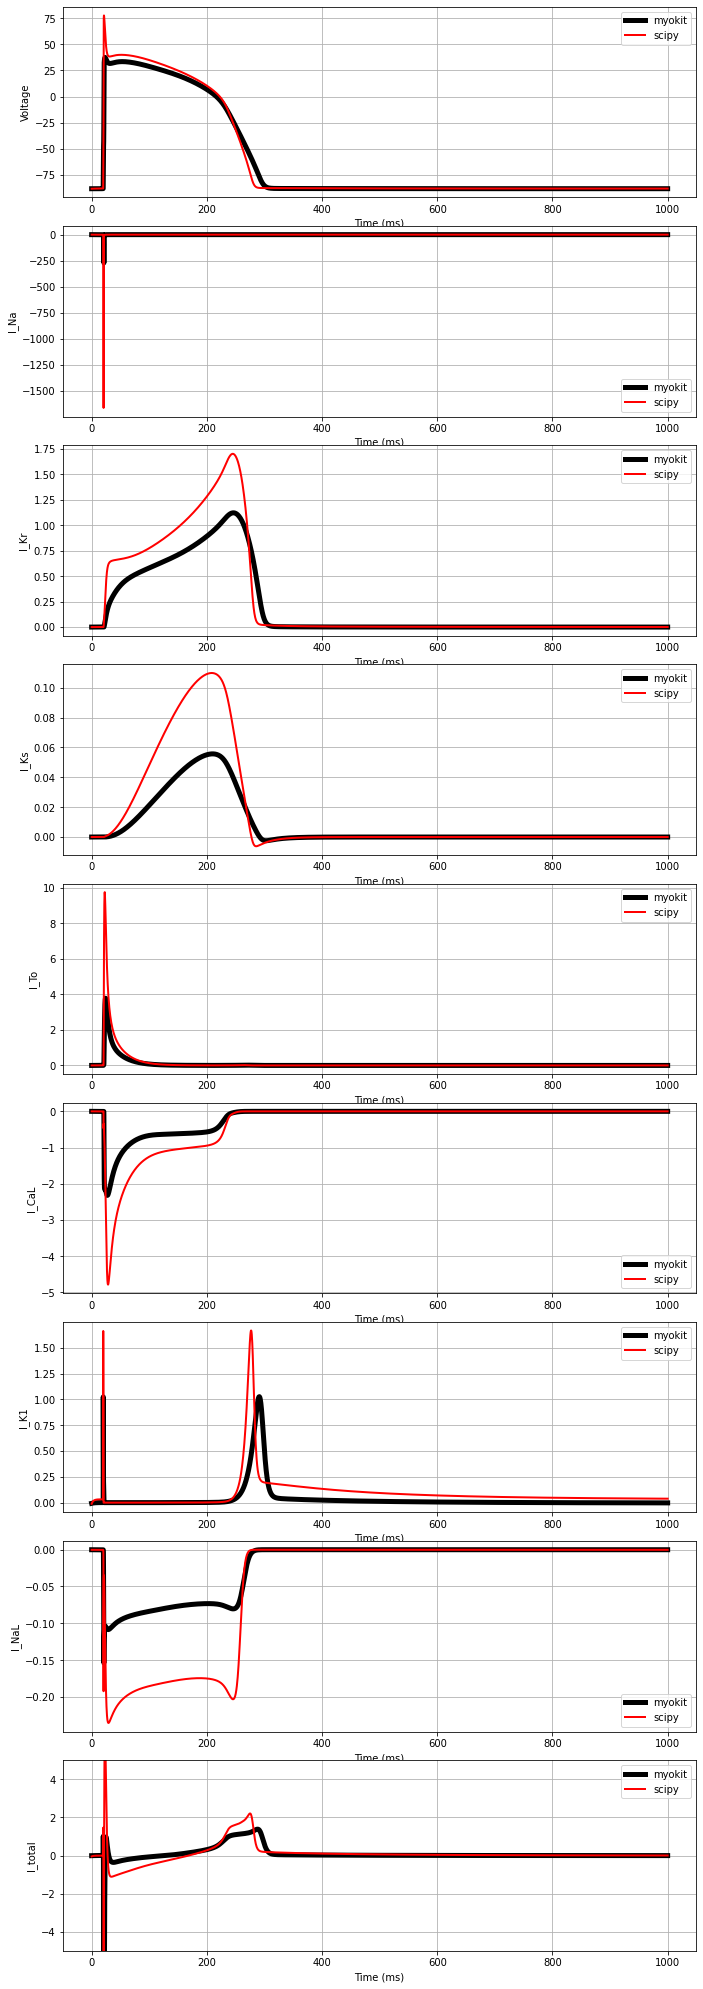

In [5]:
'''
Plot
'''
fig, ax = plt.subplots(len(sol1),1, figsize=(10,30))    
# fig.suptitle(sim.name, fontsize=14)
for i, (name, values) in enumerate(sol1.items()):    
    # ax.set_title('Simulation %d'%(simulationNo))
    # axes[i].set_xlim(model_scipy.times.min(), model_scipy.times.max())
    # ax.set_ylim(ylim[0], ylim[1])
    ax[i].set_xlabel('Time (ms)')       
    ax[i].set_ylabel(f'{name}')      
    ax[i].plot( times1, values, label='myokit', color='k', linewidth=5)     
    ax[i].plot( times2, sol2[name], label='scipy', color='r', linewidth=2)    
    ax[i].legend()
    ax[i].grid()

ax[-1].set_ylim(-5, 5)

plt.subplots_adjust(left=0.07, bottom=0.05, right=0.95, top=0.95, wspace=0.5, hspace=0.15)
plt.show()
fig.savefig(os.path.join('Results', "Protocol_test.jpg"), dpi=100)